# Einführung
### Ziel des Projekts:
Unser Ziel in diesem Projekt war es, ein ML-Modell zu erstellen, das basierend auf gegebenen Merkmalen (Features) eine Vorhersage über eine Zielvariable (Target) treffen kann. Die Daten wurden uns in Form von drei verschiedenen Dateien zur Verfügung gestellt: train.csv, test.csv und greeks.csv.

### Datenverständnis:
Die train.csv-Datei enthält die Trainingsdaten, die wir verwenden, um unser Modell zu trainieren. Diese Daten enthalten eine Reihe von Merkmalen sowie die *Zielvariable* (die Klasse, die wir vorhersagen wollten). Die test.csv-Datei enthält die Testdaten, die wir verwenden, um die Vorhersagefähigkeit unseres Modells zu überprüfen. Die greeks.csv-Datei enthält zusätzliche Merkmale, die wir in unseren Trainings- und Testdatensatz integriert haben, um die Vorhersagefähigkeit des Modells zu verbessern.

*Hier handelt es sich um ein binäres Klassifikationsproblem und wir versuchen die Vorhersagen als Wahrscheinlichkeiten zu machen*

# 0. Daten importieren

In [37]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import log_loss
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Laden und Vorbereiten der Daten
Hier laden wir unsere Daten. Wir führen einige Data Preprocessing durch, wie z.B. das Ersetzen der Alpha-Werte durch numerische Werte und das Umwandeln der kategorialen Spalten in "Greeks" in numerische Werte. Schließlich fügen wir die zusätzlichen Daten aus "Greeks" in unsere Trainingsdaten ein.

In [38]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
greeks_df = pd.read_csv('greeks.csv')

# ersetze die Alpha's durch numerische Variablen
greeks_df['Alpha'] = greeks_df['Alpha'].replace({'A': 0, 'B': 1, 'D': 1, 'G': 1})

# Erstellen eines LabelEncoder-Objekts
le = LabelEncoder()

# Umwandeln der kategorialen Spalten in greeks_df in numerische Werte
for col in ['Beta', 'Gamma', 'Delta', 'Epsilon']:
    greeks_df[col] = le.fit_transform(greeks_df[col])

# Zusammenführen der Trainingsdaten mit den zusätzlichen Daten
train_df = pd.merge(train_df, greeks_df, on='Id')
train_df.head()


,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,GF,GH,GI,GL,Class,Alpha,Beta,Gamma,Delta,Epsilon
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,2003.810319,22.136229,69.834944,0.120343,1,1,2,4,3,76
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,27981.562750,29.135430,32.131996,21.978000,0,0,2,6,1,197
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,13676.957810,28.022851,35.192676,0.196941,0,0,2,6,1,197
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,2094.262452,39.948656,90.493248,0.155829,0,0,2,6,1,197
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8524.370502,45.381316,36.262628,0.096614,1,1,1,3,1,79


# 2. k-fold Cross-Validation
### Was ist Kreuzvalidierung? 
Die Kreuzvalidierung ist eine Methode zur Evaluierung der Leistung eines maschinellen Lernmodells, die insbesondere bei kleineren Datensätzen hilfreich ist. Bei der k-fachen Kreuzvalidierung wird der Datensatz in k gleich große Teile (Folds) aufgeteilt. Dann wird das Modell k Mal trainiert und validiert, wobei in jedem Durchgang ein anderer Fold zur Validierung und die restlichen k-1 Folds zum Training verwendet werden. Wir wählen k = 5.

Der for-Loop teilt die Daten in Folds auf. Für jeden Fold speichert er den Index des Folds (beginnend mit 0) in der "Fold"-Spalte für die Beobachtungen, die in diesem Fold zur Validierung verwendet werden sollen. 

In [39]:
# Festlegen der Anzahl der Faltungen (Folds)
# der Datensatz wird in 5 Teile aufgeteilt.
n_folds = 5

# Erstellen einer Spalte für die Fold-Nummer
# Diese Spalte wird dazu verwendet, die Zugehörigkeit jeder Beobachtung zu einem bestimmten Fold zu speichern.
train_df['Fold'] = -1

# Erstellen eines StratifiedKFold-Objekts
# shuffle=True stellt sicher, dass die Daten vor der Aufteilung in Folds zufällig durchmischt werden.
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

# Aufteilen der Daten in Folds
for fold, (train_idx, valid_idx) in enumerate(skf.split(train_df, train_df['Class'])):
    train_df.loc[valid_idx, 'Fold'] = fold


# 3. Vorbereiten der Daten für das Modell
Wir bereiten unsere Daten für das Machine Learning vor. Wir wenden One-Hot-Encoding auf die 'EJ'-Spalte an, um diese kategoriale Spalte in eine Form zu bringen, die von unserem Modell verwendet werden kann. Wir entfernen die ursprüngliche 'EJ'-Spalte und fügen die kodierten Spalten zu unseren Daten hinzu. Wir definieren die Merkmale, die wir zum Trainieren unseres Modells verwenden werden, und unsere Zielvariable, die wir vorhersagen möchten.

In [40]:
# Erstellen des OneHotEncoder-Objekts
encoder = OneHotEncoder(sparse=False, drop='first')

# Anpassen des Encoders und Umwandeln der 'EJ'-Spalte in den Trainings- und Testdaten
ej_encoded_train = encoder.fit_transform(train_df[['EJ']])
ej_encoded_test = encoder.transform(test_df[['EJ']])

# Erstellen von Feature-Namen für die kodierten Spalten
feature_names = ['EJ_' + str(i) for i in range(ej_encoded_train.shape[1])]

# Erstellen eines DataFrame aus der kodierten 'EJ'-Spalte
ej_encoded_train_df = pd.DataFrame(ej_encoded_train, columns=feature_names)
ej_encoded_test_df = pd.DataFrame(ej_encoded_test, columns=feature_names)

# Löschen der ursprünglichen 'EJ'-Spalte aus den Trainings- und Testdaten
train_df = train_df.drop(columns=['EJ'])
test_df = test_df.drop(columns=['EJ'])

# Verknüpfen der Trainings- und Testdaten mit dem kodierten 'EJ'-DataFrame
train_df = pd.concat([train_df, ej_encoded_train_df], axis=1)
test_df = pd.concat([test_df, ej_encoded_test_df], axis=1)

# Vorbereiten der Feature- und Zielvariablen
features = [col for col in train_df.columns if col not in ['Id', 'Class', 'Fold'] and col in test_df.columns]
target = 'Class'

/Users/keonhyeonglee/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


# 4. Training und Validierung des Modells
Hier trainieren und validieren wir unser Modell. Für jede Fold teilen wir die Daten in Trainings- und Validierungsdaten auf, trainieren das Modell auf den Trainingsdaten und validieren es auf den Validierungsdaten. Wir sammeln die Vorhersagen für die Validierungsdaten und die Wichtigkeit der Merkmale für jedes Modell. Wir berechnen auch den Out-of-Fold-Score, der ein Maß für die Leistung unseres Modells auf den Validierungsdaten ist. Schließlich speichern wir jedes trainierte Modell für die spätere Verwendung.

In diesem Codeblock bereiten wir die Validierungsvorhersagen und Feature-Importanzen vor und initialisieren die Out-of-Fold-Score. Wir trainieren und validieren dann das Modell für jede Falte. Wir bereiten die Trainings- und Validierungsdaten vor, definieren das Modell und trainieren es. Wir validieren das Modell und speichern die Validierungsvorhersagen. Wir aktualisieren die Out-of-Fold-Score basierend auf den Validierungsvorhersagen und speichern die Feature-Importanzen. Schließlich speichern wir das trainierte Modell und stellen die Feature-Importanzen dar.

/Users/keonhyeonglee/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/keonhyeonglee/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Training and validating fold 0...


Out-of-Fold-Score for Fold 0: 0.13792252203782837


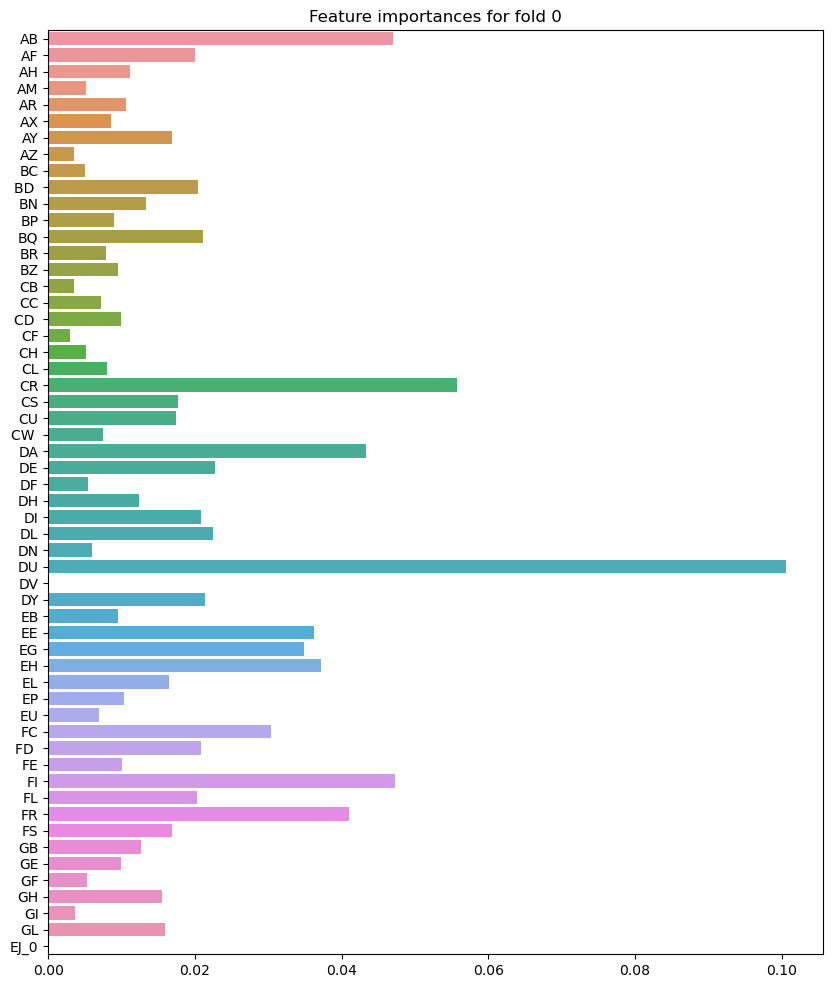

Training and validating fold 1...


/Users/keonhyeonglee/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/keonhyeonglee/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Out-of-Fold-Score for Fold 1: 0.21485778708892203


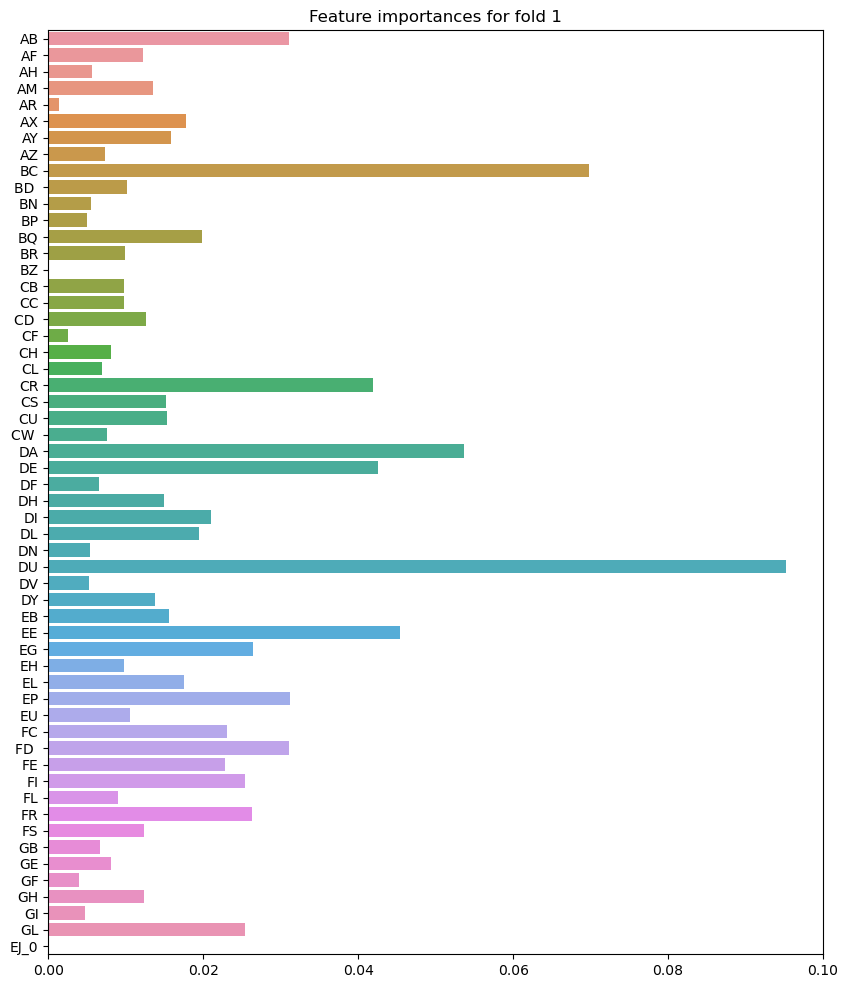

Training and validating fold 2...


/Users/keonhyeonglee/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/keonhyeonglee/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Out-of-Fold-Score for Fold 2: 0.13937799451923316


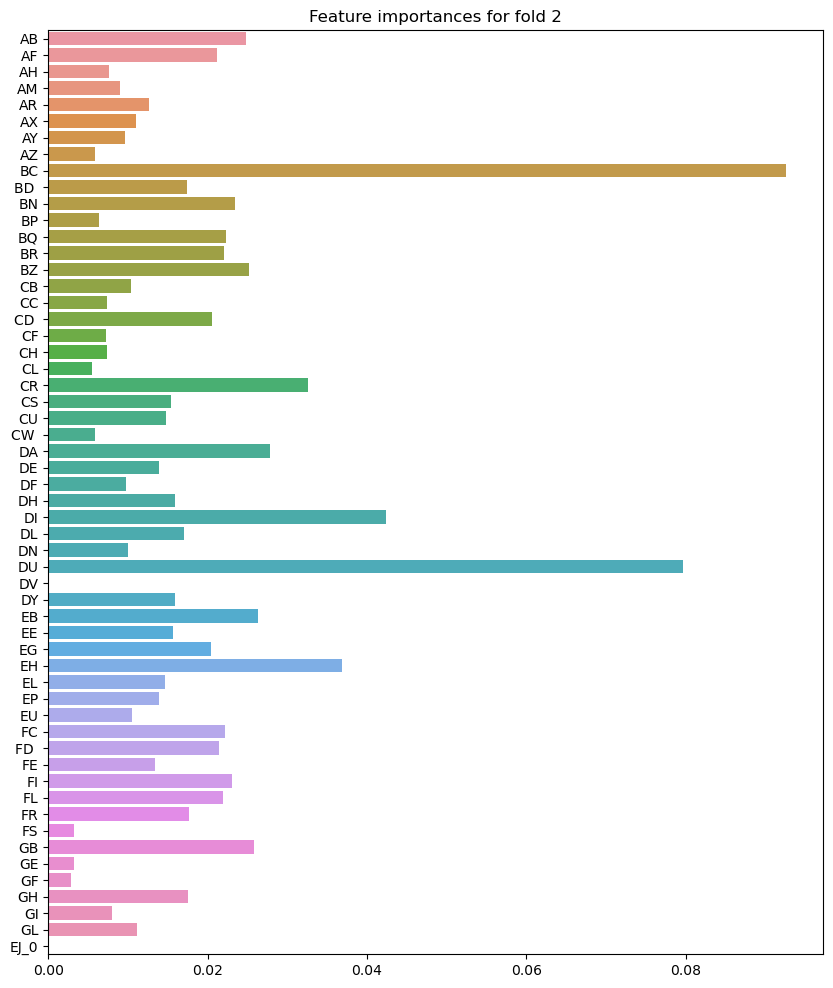

Training and validating fold 3...


/Users/keonhyeonglee/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/keonhyeonglee/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Out-of-Fold-Score for Fold 3: 0.2504820679618764


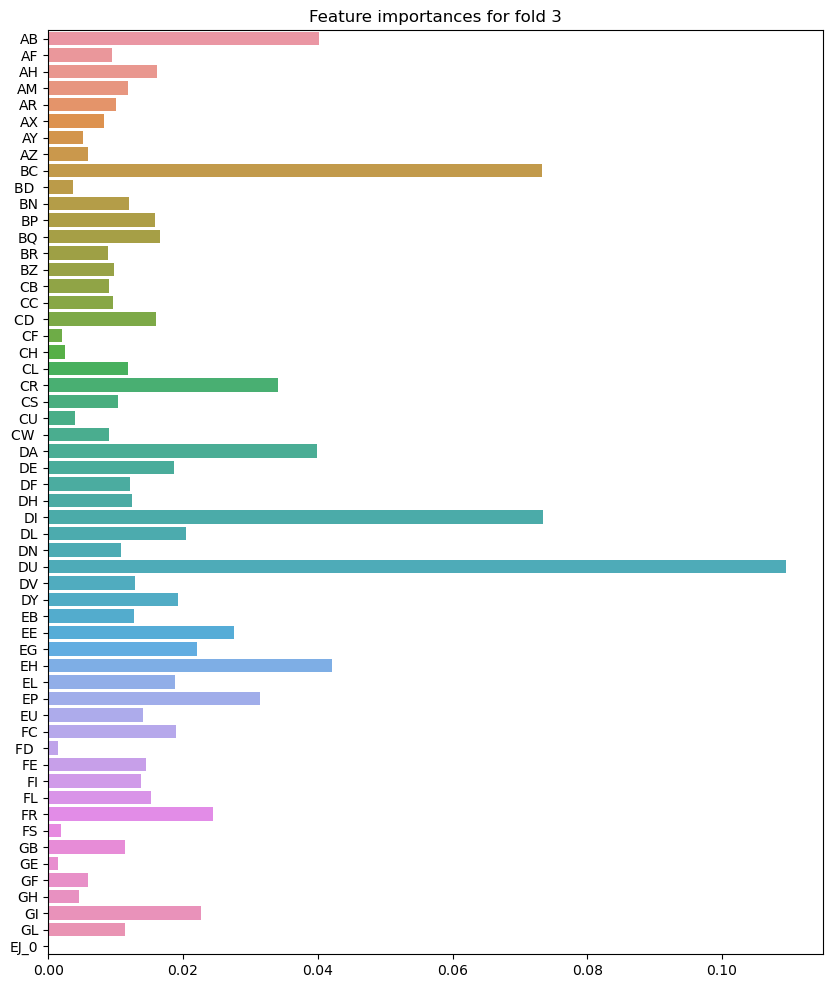

Training and validating fold 4...


/Users/keonhyeonglee/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/keonhyeonglee/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Out-of-Fold-Score for Fold 4: 0.19363618329905785


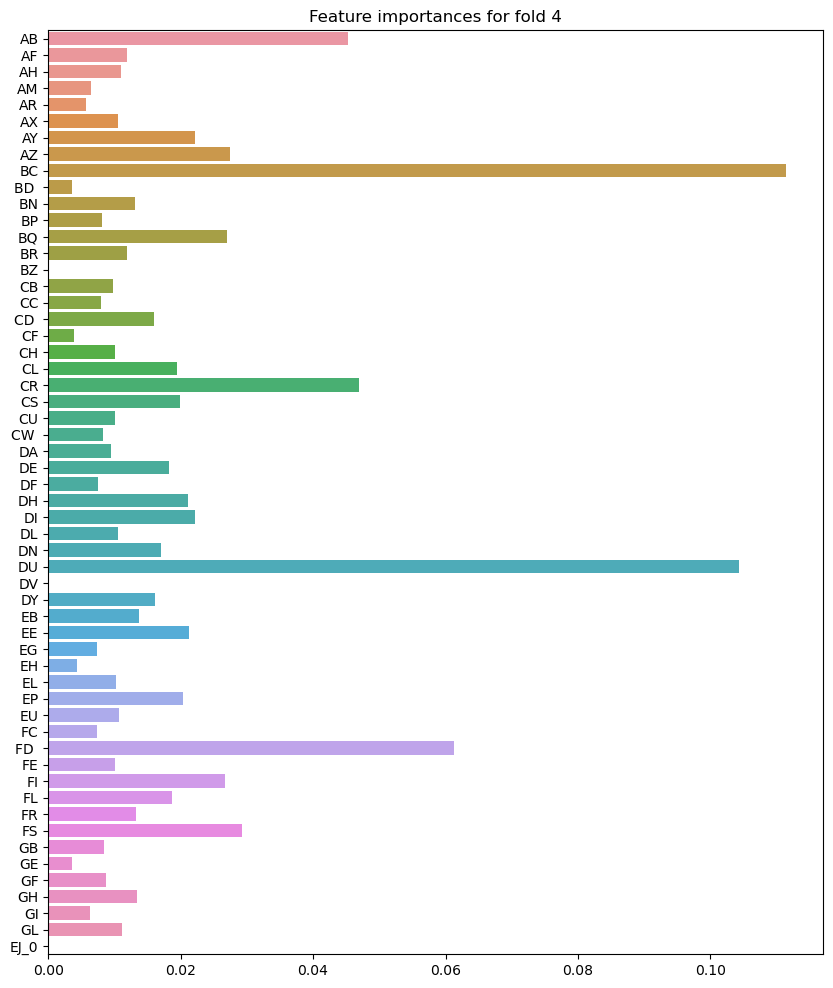

In [41]:
oof_preds = {}
feature_importances = []

# Initialisiere den Out-of-Fold-Score
oof_score = 0

# Trainieren und Validieren des Modells
for fold in range(n_folds):
    print(f'Training and validating fold {fold}...')
    
    train_data = train_df[train_df['Fold'] != fold]
    valid_data = train_df[train_df['Fold'] == fold]
    
    X_train = train_data[features]
    y_train = train_data[target]
    X_valid = valid_data[features]
    y_valid = valid_data[target]
    
    # Definition des Modells - XGBClassifier
    model = XGBClassifier(n_estimators=4000, learning_rate=0.01, use_label_encoder=False, random_state=42)

    # Trainieren des Modells
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=100, verbose=False)

    # Validieren des Modells
    valid_preds = model.predict_proba(X_valid)[:, 1]
    oof_preds[f'Fold_{fold}'] = valid_preds
    
    # Aktualisieren der Out-of-Fold-Score
    fold_score = log_loss(y_valid, valid_preds)
    oof_score += fold_score / n_folds

    # Erhalten der Feature-Importanzen
    feature_importances.append(model.feature_importances_)

    # Speichern
    joblib.dump(model, f'model_fold_{fold}.joblib')
    
    # Ausgabe von fold score
    print(f'Out-of-Fold-Score for Fold {fold}: {fold_score}')
    
    # Plot - Grafik
    plt.figure(figsize=(10, 12))
    plt.title(f'Feature importances for fold {fold}')
    sns.barplot(x=model.feature_importances_, y=features)
    plt.show()

# 5. Auswertung der Ergebnisse
Schließlich berechnen wir die durchschnittliche Wichtigkeit jedes Merkmals über alle Folds und sortieren die Merkmale nach ihrer Wichtigkeit. Wir drucken den Out-of-Fold-Score und die Wichtigkeit der Merkmale aus. Wir machen Vorhersagen für die Testdaten `submission` und speichern ab.

In [42]:
# Durchschnitt von Feature-Importanzen
avg_feature_importances = np.mean(feature_importances, axis=0)

# DataFrame, um die Feature-Importanzen zu speichern
importance_df = pd.DataFrame({'Feature': features, 'Importance': avg_feature_importances})

# Sortieren des DataFrame nach der Wichtigkeit
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print('Out of Fold Score:', oof_score)
print('Feature Importances:', importance_df)

# Vorhersagen der Testdaten
test_preds = model.predict_proba(test_df[features])

# Submission
submission_df = pd.DataFrame({'Id': test_df['Id'], 'class_0': test_preds[:, 0], 'class_1': test_preds[:, 1]})
submission_df.to_csv('submission.csv', index=False)
submission_df.head()

Out of Fold Score: 0.18725531098138357
Feature Importances:    Feature  Importance
32      DU    0.097883
8       BC    0.070444
21      CR    0.042265
0       AB    0.037646
29      DI    0.035951
25      DA    0.034843
36      EE    0.029197
45      FI    0.027240
43     FD     0.027174
38      EH    0.026060
47      FR    0.024540
26      DE    0.023225
37      EG    0.022234
40      EP    0.021427
12      BQ    0.021348
42      FC    0.020381
30      DL    0.017973
34      DY    0.017282
46      FL    0.017025
22      CS    0.015676
35      EB    0.015569
39      EL    0.015525
28      DH    0.015338
17     CD     0.014994
54      GL    0.014987
1       AF    0.014929
44      FE    0.014140
6       AY    0.013930
10      BN    0.013467
49      GB    0.012957
48      FS    0.012705
52      GH    0.012667
23      CU    0.012310
13      BR    0.012099
5       AX    0.011229
9      BD     0.011023
41      EU    0.010530
2       AH    0.010317
20      CL    0.010316
7       AZ    0.0099

,Id,class_0,class_1
0,00eed32682bb,0.897392,0.102608
1,010ebe33f668,0.897392,0.102608
2,02fa521e1838,0.897392,0.102608
3,040e15f562a2,0.897392,0.102608
4,046e85c7cc7f,0.897392,0.102608


Die Ausgabe in der `submission.csv`-Datei enthält die Vorhersageprognosen für jede Klasse (class_0 und class_1) für jedes Element im Testdatensatz. 

Hierbei handelt es sich um Vorhersagewahrscheinlichkeiten, die von unserem Modell erzeugt wurden. Für jede Zeile (jede ID) summiert sich die Vorhersagewahrscheinlichkeit für class_0 und class_1 zu 1. 

Die Interpretation der Ausgabe ist wie folgt: 

- class_0: Das ist die Wahrscheinlichkeit, dass das Element zur Klasse 0 gehört, laut unserem Modell. In unserem Beispiel liegt diese Wahrscheinlichkeit bei etwa 0,9 oder 90%, was bedeutet, dass das Modell stark davon ausgeht, dass das Element zur Klasse 0 gehört.
  
- class_1: Das ist die Wahrscheinlichkeit, dass das Element zur Klasse 1 gehört, laut unserem Modell. In unserem Beispiel liegt diese Wahrscheinlichkeit bei etwa 0,1 oder 10%, was bedeutet, dass das Modell weniger stark davon ausgeht, dass das Element zur Klasse 1 gehört.

Diese Art der Ausgabe ist typisch für Klassifizierungsprobleme, insbesondere wenn die Vorhersagewahrscheinlichkeiten für jede Klasse gefragt sind. Es bietet eine nuanciertere Ansicht der Modellvorhersagen als nur eine harte Klassenzuweisung, da es den Grad der Unsicherheit des Modells in seinen Vorhersagen zeigt. 

Es ist jedoch wichtig zu beachten, dass diese Vorhersagewahrscheinlichkeiten auf den Daten basieren, mit denen das Modell trainiert wurde, und auf der Annahme, dass die Testdaten eine ähnliche Verteilung aufweisen. Wenn die Testdaten sehr anders aussehen als die Trainingsdaten, könnten die Vorhersagewahrscheinlichkeiten ungenau sein.

# 6. Zusammenfassung
Hier wird die durchschnittliche Wichtigkeit jedes Features über alle Folds hinweg berechnet und visualisiert.
Diese Visualisierung hilft uns, zu verstehen, welche Features das Modell als am wichtigsten für die Vorhersage der Zielvariable erachtet. Somit können wir die Ergebnisse des Modells besser interpretieren und verstehen, welche Informationen für die Vorhersage am wertvollsten sind.

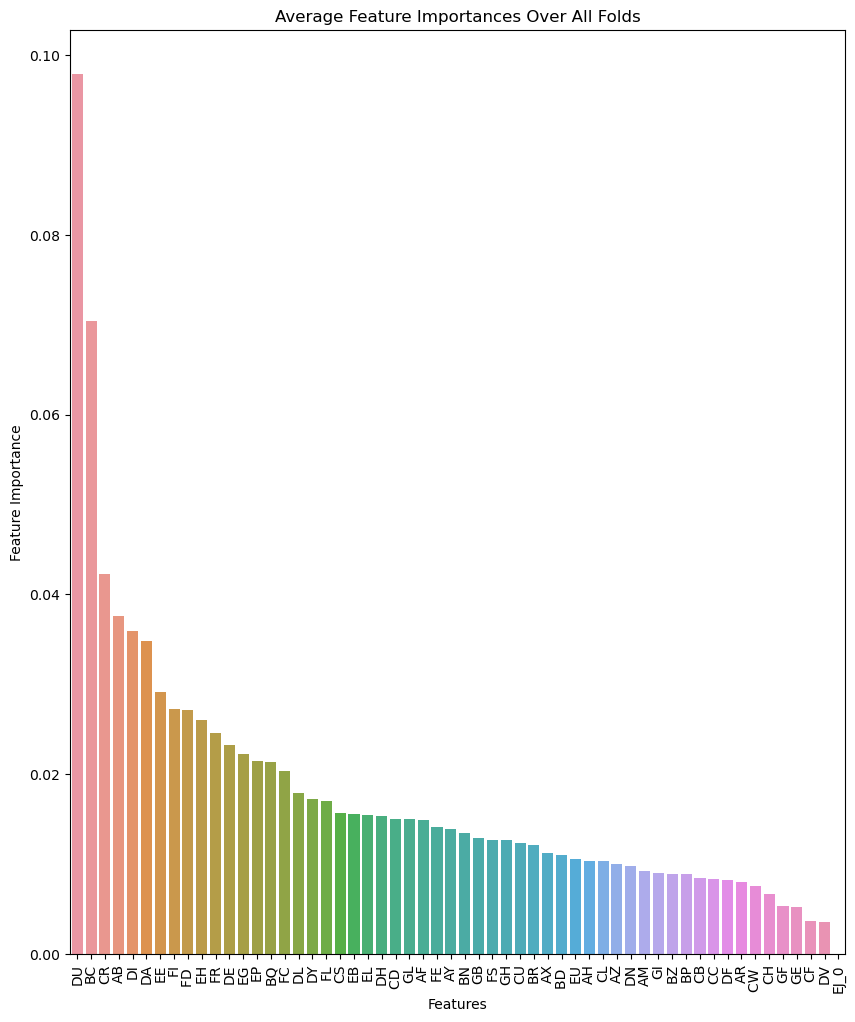

In [43]:
# Zusammenfassung der Feature Importance aller Folds
importance_df_summary = importance_df.groupby("Feature").mean().reset_index()

# Sortieren der Merkmale nach ihrer durchschnittlichen Wichtigkeit
importance_df_summary = importance_df_summary.sort_values(by='Importance', ascending=False)

# Darstellung der Merkmalswichtigkeiten
plt.figure(figsize=(10, 12))
plt.title('Average Feature Importances Over All Folds')
sns.barplot(y="Importance", x="Feature", data=importance_df_summary, orient='v')  # Vertauschen der x und y-Achse
plt.ylabel('Feature Importance')  # Y-Achse
plt.xlabel('Features')  # X-Achse
plt.xticks(rotation=90)  # Rotation der X-Achsen-Beschriftungen um 90 Grad für bessere Lesbarkeit
plt.show()


# 7. Korrelationsmatrix
Wir erstennen noch eine Korrelationsmatrix, die visualisiert, wie stark die Features in den Trainingsdaten miteinander korrelieren.
Mit dieser Information kann man möglicherweise Merkmale identifizieren, die stark miteinander korreliert sind. D.h., dass sie ähnliche Informationen über die Zielvariable liefern. In solchen Fällen kann man in Erwägung ziehen, eines der korrelierten Merkmale zu entfernen, um die Dimensionalität des Datensatzes zu reduzieren und möglicherweise die Leistung des Modells zu verbessern.

<Axes: >

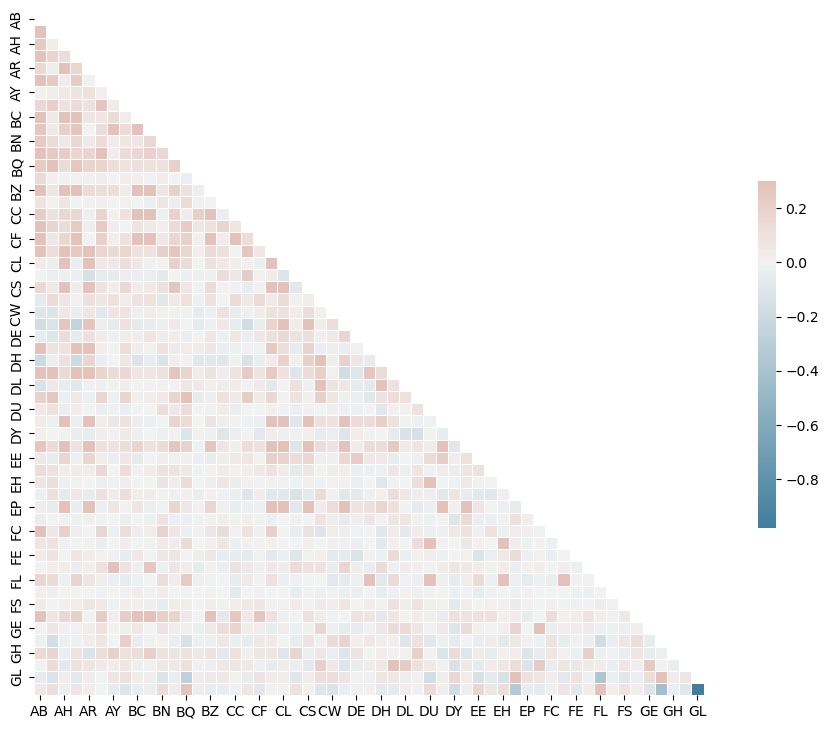

In [44]:
# Berechnen der Korrelationsmatrix
corr = train_df[features].corr()

# Erstellen einer Maske für das obere Dreieck
mask = np.triu(np.ones_like(corr, dtype=bool))

# Einstellen der Matplotlib-Figur
f, ax = plt.subplots(figsize=(11, 9))

# Generieren einer benutzerdefinierten divergierenden Farbpalette
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Zeichnen der Heatmap mit der Maske und korrekter Seitenverhältnisanpassung
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})